In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c

import iminuit 
from iminuit import Minuit, cost
import ROOT

import mplhep as hep
mpl.style.use(hep.style.ATLAS)




Welcome to JupyROOT 6.24/02


    mpl.rcParams['font.size'] = 8
    mpl.rcParams['figure.dpi'] = 200

Analisi per ottenere valore di $\gamma$. Conosciamo la relazione di fit che è $$ I = \alpha\cdot V^{\frac{4\gamma-1}{4\gamma+1}} $$

In [2]:
V, μ_I, σ_I = np.loadtxt('lamp.txt', unpack=True)

def f(V, α, γ):
    return α*(V**((4*γ-1)/(4*γ+1)))

χ2= cost.LeastSquares(V, μ_I, σ_I, model=f)

m_γ = Minuit(χ2, α=1e-2, γ=0.8)
m_γ.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.791e+04 (chi2/ndof = 182.7)│              Nfcn = 61               │
│ EDM = 5.43e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │11.9805e-3 │ 0.0027e-3 │            │            │         │         │       │
│ 1 │ γ    │ 877.69e-3 │  0.24e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         α         γ │
├───┼─────────────────────┤
│ α │  7.22e-12 -6.12e-10 │
│ γ │ -6.12e-10  5.68e-08 │
└───┴─────────────────────┘

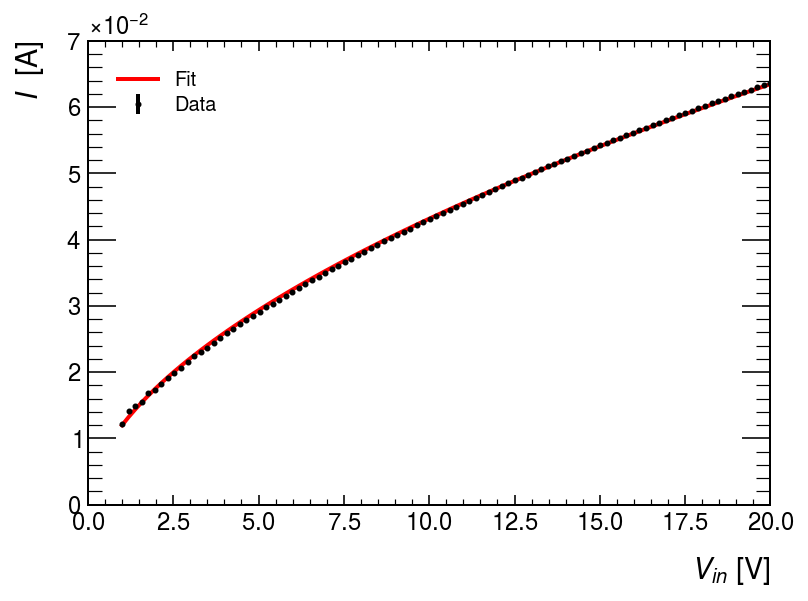

In [3]:
fig, ax = plt.subplots()

ax.set_xlabel('$V_{in}$ [V]')
ax.set_ylabel('$I$  [A]')
ax.errorbar(V, μ_I, σ_I, fmt='k.', markersize=4, label='Data')
ax.plot(V, f(V, *m_γ.values), 'r', label='Fit')
ax.legend()

In [4]:
fig.savefig('../report/fig/gamma_plot.pdf', bbox_inches='tight')

In [5]:
γ, σ_γ = m_γ.values['γ'], m_γ.errors['γ']

from uncertainties import ufloat
print(f'γ = {ufloat(γ, σ_γ):.3uS}')

σ_γ/γ

γ = 0.877687(238)


0.0002715560568118119

$$ T_i = T_{amb} \left(\frac{V_i}{I_i R_{amb}}\right)^\gamma $$

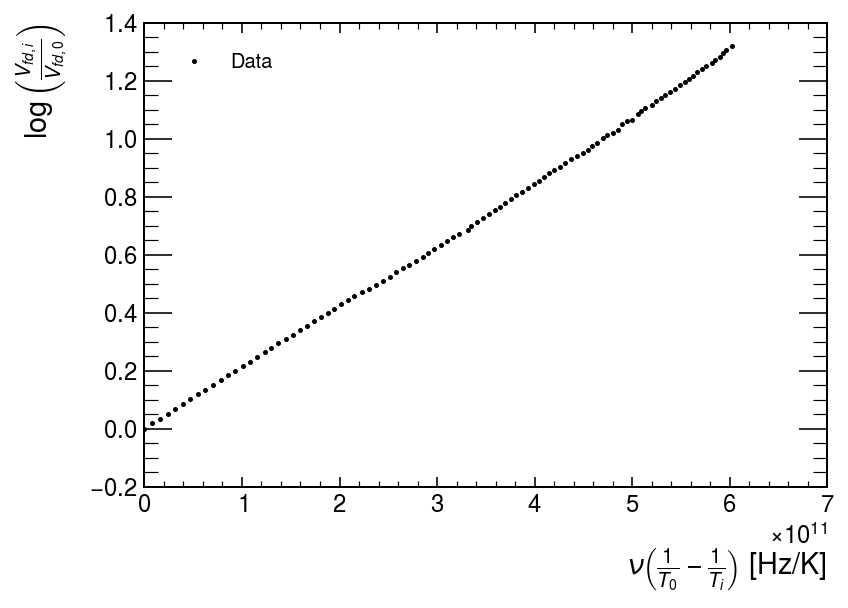

In [6]:
def T(T_amb, R_amb, V, I, γ):
    return T_amb * ( V/(I*R_amb) )**γ


V, μ_I, σ_I, μ_Vfd, σ_Vfd = np.loadtxt('ph_diode.txt', unpack=True)

T_amb = 20
σ_T_amb = 1
R_amb, σ_R_amb = 25.045, 0.21551350000000002

ν, σ_ν = c/450e-9, (10/(2*np.log(2+np.sqrt(3))))*c/450e-9**2

μ_T = T(T_amb, R_amb, V, μ_I, γ)

def log(i, j):
    return np.log(μ_Vfd[i]/μ_Vfd[j])

def Tij(i, j, ν):
    return ν*(1/μ_T[j]-1/μ_T[i])

j: int = 0
LOG = np.array([log(i, j) for i in range(len(μ_Vfd))])
TEMP_DIFF =  np.array([Tij(i, j, ν) for i in range(len(V))])

fig, ax = plt.subplots()
ax.set_xlabel(r'$\nu\left(\frac{1}{T_%d} - \frac{1}{T_i}\right)$ [Hz/K]'%j, labelpad=15)
ax.set_ylabel(r'$\log\left(\frac{V_{fd,i}}{V_{fd,%d}}\right)$'%j)
ax.plot(TEMP_DIFF, LOG, 'k.', markersize=3, label='Data')
ax.legend()

In [7]:
# T(T_amb, R_amb, V, I, γ)

σ_T = np.zeros_like(μ_T)

'''
for i in range(len(σ_T)):
    
    σ2 = 0
    
    σ_T_amb_p = np.abs(T(T_amb + σ_T_amb, R_amb, V[i], μ_I[i], γ) - μ_T[i])
    σ_T_amb_n = np.abs(T(T_amb - σ_T_amb, R_amb, V[i], μ_I[i], γ) - μ_T[i])
    if np.abs(σ_T_amb_n - σ_T_amb_p) < (σ_T_amb / T_amb) * np.max([σ_T_amb_n, σ_T_amb_p]):
        σ2 += np.max([σ_T_amb_n, σ_T_amb_p])**2
    else:
        print('T_amb: %.5f != %.5f'%(σ_T_amb_n, σ_T_amb_p))

    σ_γ_p = np.abs(T(T_amb, R_amb, V[i], μ_I[i], γ + σ_γ) - μ_T[i])
    σ_γ_n = np.abs(T(T_amb, R_amb, V[i], μ_I[i], γ - σ_γ) - μ_T[i])
    if np.abs(σ_γ_n - σ_γ_p) < (σ_γ / γ) * np.max([σ_γ_n, σ_γ_p]):
        σ2 += np.max([σ_γ_n, σ_γ_p])**2
    else:
        print('γ:     %.5f != %.5f'%(σ_γ_n, σ_γ_p))
        
    σ_I_p = np.abs(T(T_amb, R_amb, V[i], μ_I[i] + σ_I[i], γ) - μ_T[i])
    σ_I_n = np.abs(T(T_amb, R_amb, V[i], μ_I[i] - σ_I[i], γ) - μ_T[i])
    if np.abs(σ_I_n - σ_I_p) < (σ_I[i] / μ_I[i]) * np.max([σ_I_n, σ_I_p]):
        σ2 += np.max([σ_I_n, σ_I_p])**2
    else:
        print('μ_I:   %.5f != %.5f'%(σ_I_n, σ_I_p))
    
    σ_R_amb_p = np.abs(T(T_amb, R_amb + σ_R_amb, V[i], μ_I[i], γ) - μ_T[i])
    σ_R_amb_n = np.abs(T(T_amb, R_amb - σ_R_amb, V[i], μ_I[i], γ) - μ_T[i])
    if np.abs(σ_R_amb_n - σ_R_amb_p) < (σ_R_amb / R_amb) * np.max([σ_R_amb_n, σ_R_amb_p]):
        σ2 += np.max([σ_R_amb_n, σ_R_amb_p])**2
    else:
        print('R_amb: %.5f != %.5f'%(σ_R_amb_n, σ_R_amb_p))

    
    σ_T[i] = np.sqrt(σ2)
    '''


σ_T


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
σ_MC = np.zeros_like(σ_T)

def MC_f(R_amb, V, I, γ):
    return ( V / (I * R_amb) )**γ

n_samples = 100_000

rnd = ROOT.TRandom3(2191070958714)

for i in range(len(σ_MC)):
    MC_f_reco = ROOT.TH1D('', '', 100, 0, 0)
    for _ in range(n_samples):
        MC_f_reco.Fill(
            MC_f(
                rnd.Gaus(R_amb, σ_R_amb),
                V[i],
                rnd.Gaus(μ_I[i], σ_I[i]),
                rnd.Gaus(γ, σ_γ)
            )
        )
    σ_MC[i] += MC_f_reco.GetStdDev()





σ_T = np.sqrt(σ_T_amb**2 + σ_MC**2)


In [9]:

μ_Vfd[0], np.max(μ_Vfd), np.max(μ_Vfd)/μ_Vfd[0]



(0.030139, 0.112776, 3.7418627028103124)

$\ln(x)\sim x$ in un intorno di $x$ in [1,3] che sono i valori di interesse

In [10]:
σ_LOG = np.zeros_like(LOG)

def log(Vi, Vj):
    return np.log(Vi/Vj)

def Tij(Ti, Tj, ν):
    return ν*(1/Tj-1/Ti)

for i in range(len(LOG)):
    σ2 = 0.0
    σ_Vi_p = np.abs(log(μ_Vfd[i] + σ_Vfd[i], μ_Vfd[j]) - LOG[i])
    σ_Vi_n = np.abs(log(μ_Vfd[i] - σ_Vfd[i], μ_Vfd[j]) - LOG[i])
    
    if np.abs(σ_Vi_p - σ_Vi_n) < (σ_Vfd[i] / μ_Vfd[i]) * np.max([σ_Vi_p, σ_Vi_n]):
        σ2 += np.max([σ_Vi_p, σ_Vi_n])**2
        # print('Vi %3d: linear! '%i, end='')
    else:
        print('Vi: %.10f != %.10f'%(σ_Vi_n, σ_Vi_p))
    
    σ_Vj_p = np.abs(log(μ_Vfd[i], μ_Vfd[j] + σ_Vfd[j]) - LOG[i])
    σ_Vj_n = np.abs(log(μ_Vfd[i], μ_Vfd[j] - σ_Vfd[j]) - LOG[i])
    
    if np.abs(σ_Vj_p - σ_Vj_n) < (σ_Vfd[j] / μ_Vfd[j]) * np.max([σ_Vj_p, σ_Vj_n]):
        σ2 += np.max([σ_Vj_p, σ_Vj_n])**2
        # print('Vj %3d: linear! '%i, end='')
    else:
        print('Vj: %.10f != %.10f'%(σ_Vj_n, σ_Vj_p))
    
    σ_LOG[i] += np.sqrt(σ2)

Osserviamo che in tutti i casi abbiamo linearità su entrambe le direzioni, quindi possiamo ottenere gli errori sui punti.

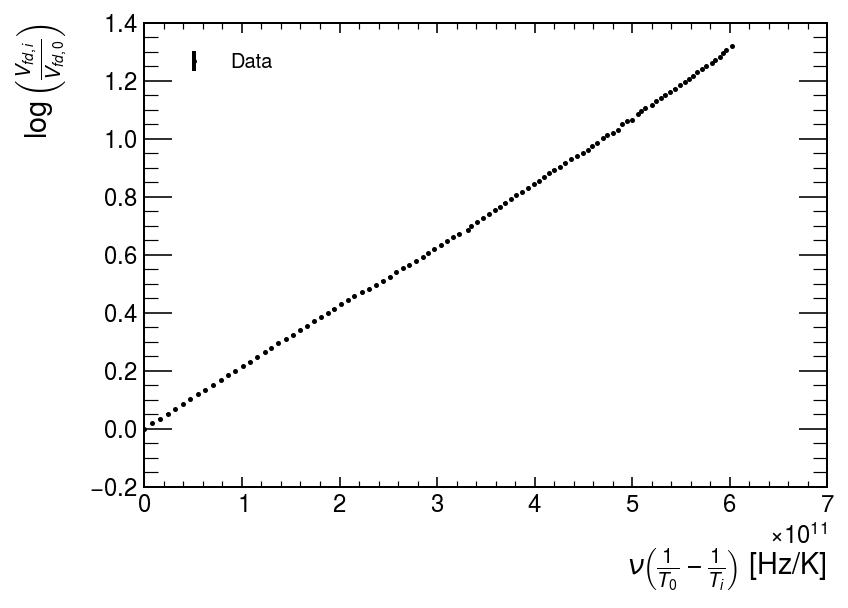

In [11]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$\nu\left(\frac{1}{T_%d} - \frac{1}{T_i}\right)$ [Hz/K]'%j, labelpad=15)
ax.set_ylabel(r'$\log\left(\frac{V_{fd,i}}{V_{fd,%d}}\right)$'%j)
ax.errorbar(TEMP_DIFF, LOG, σ_LOG, color='k', fmt='.', markersize=3, label='Data')
ax.legend()

Dobbiamo ancora calcolare il valore dell'errore che abbiamo invece sul secondo membro (nel caso poi eseguire un plot opposto se vediamo che gli errori sono più importanti)